In [17]:
#Libraries importation
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import pie
from scipy import stats as st
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

# 1. Dataset importation

In [44]:
data = pd.read_csv('dataset.csv')
data.head(15)

,Number pregnant,Plasma,pressure,thickness,insulin,mass index,Diabetes pedigree function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


# 2. General statistics

In [19]:
data.dtypes

Number pregnant                 int64
Plasma                          int64
pressure                        int64
thickness                       int64
insulin                         int64
mass index                    float64
Diabetes pedigree function    float64
Age                             int64
Class                           int64
dtype: object

All of the features are categorical.

In [20]:
data.describe()

,Number pregnant,Plasma,pressure,thickness,insulin,mass index,Diabetes pedigree function,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The number of times pregnant, thickness, insulin, diabetes pedigree and age are skewed on the right, while the other features are skewed on the left. 

### 3. Data visualization

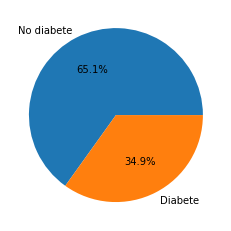

In [21]:
#Diabete's prevalence
diabete = data['Class'].value_counts()/len(data)
pie(diabete, labels=['No diabete', 'Diabete'],autopct='%1.1f%%')
plt.show()

In [22]:
def plot_distribution(dataframe, column, ax, bins=50):
    """
    Plot variable distribution in a stacked histogram of women suffering from diabete or not
    """
    #Create a temporary dataframe with the data to be plot
    temp = pd.DataFrame({'no diabete':dataframe[dataframe['Class']==0][column],
                         'diabete':dataframe[dataframe['Class']==1][column]})
    #Plot the histogram
    temp[['no diabete','diabete']].plot(kind='hist',bins=bins, ax=ax, stacked=True)
    #X-axis label
    ax.set_xlabel(column)
    #Change the x-axis to plain style
    ax.ticklabel_format(style='plain',axis='x')

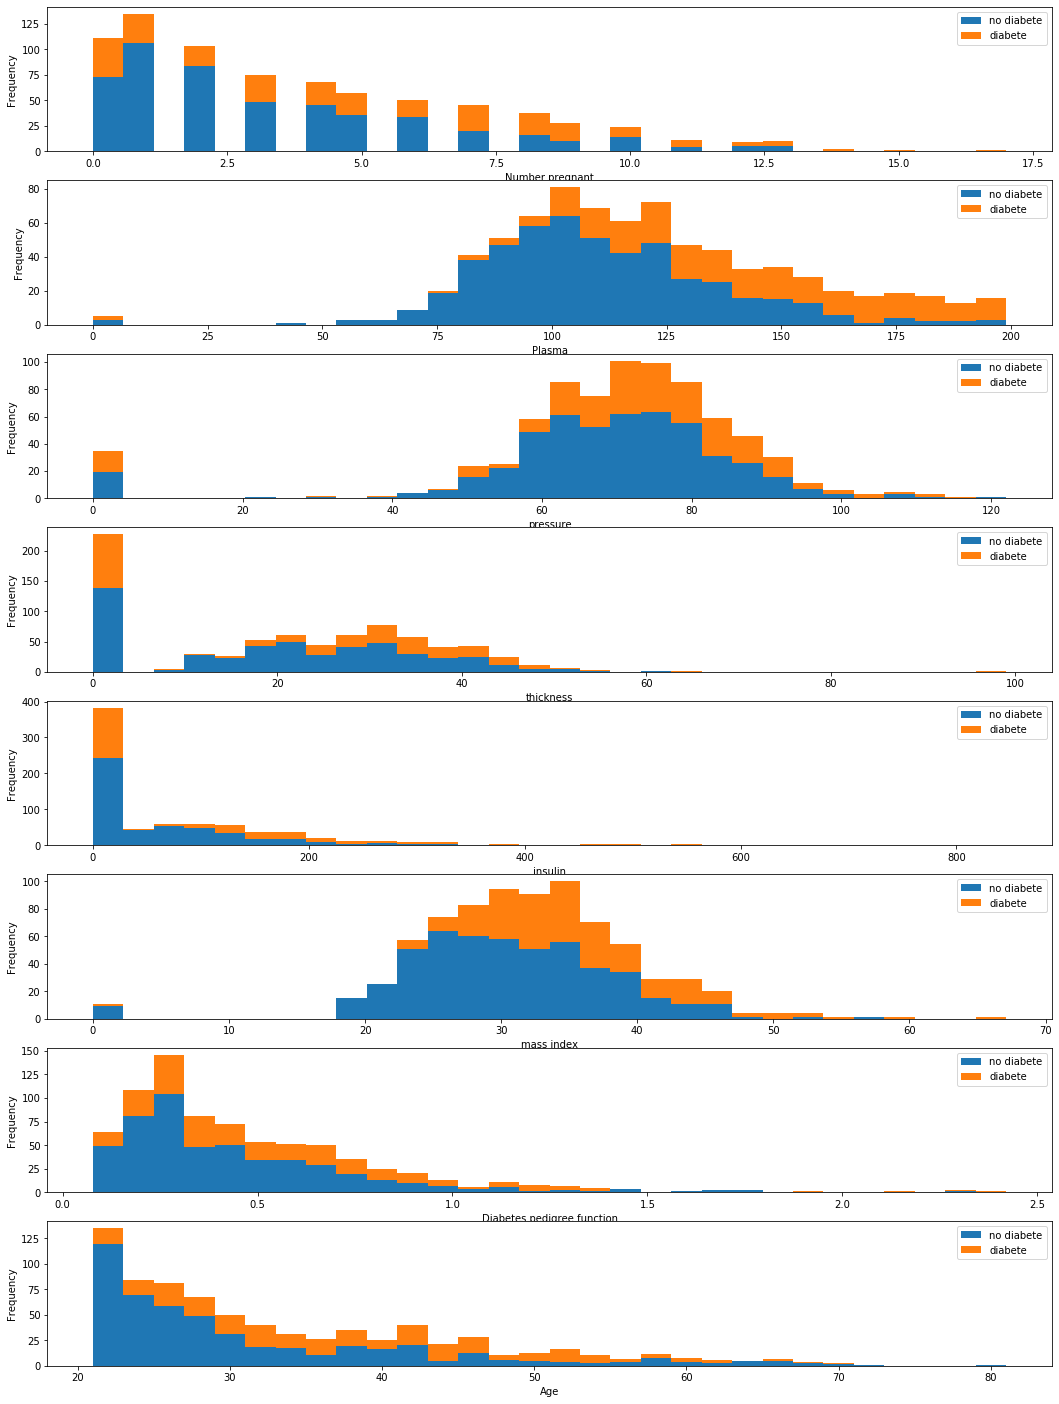

In [23]:
fig,axs = plt.subplots(nrows=8,figsize=(18,25))
#Plot histograms
i=0
for column in data.columns[:-1]:
    plot_distribution(data,column,axs[i],bins=30)
    i += 1

Many observations are likely to be outliers. Let's plot boxplots to have a better idea

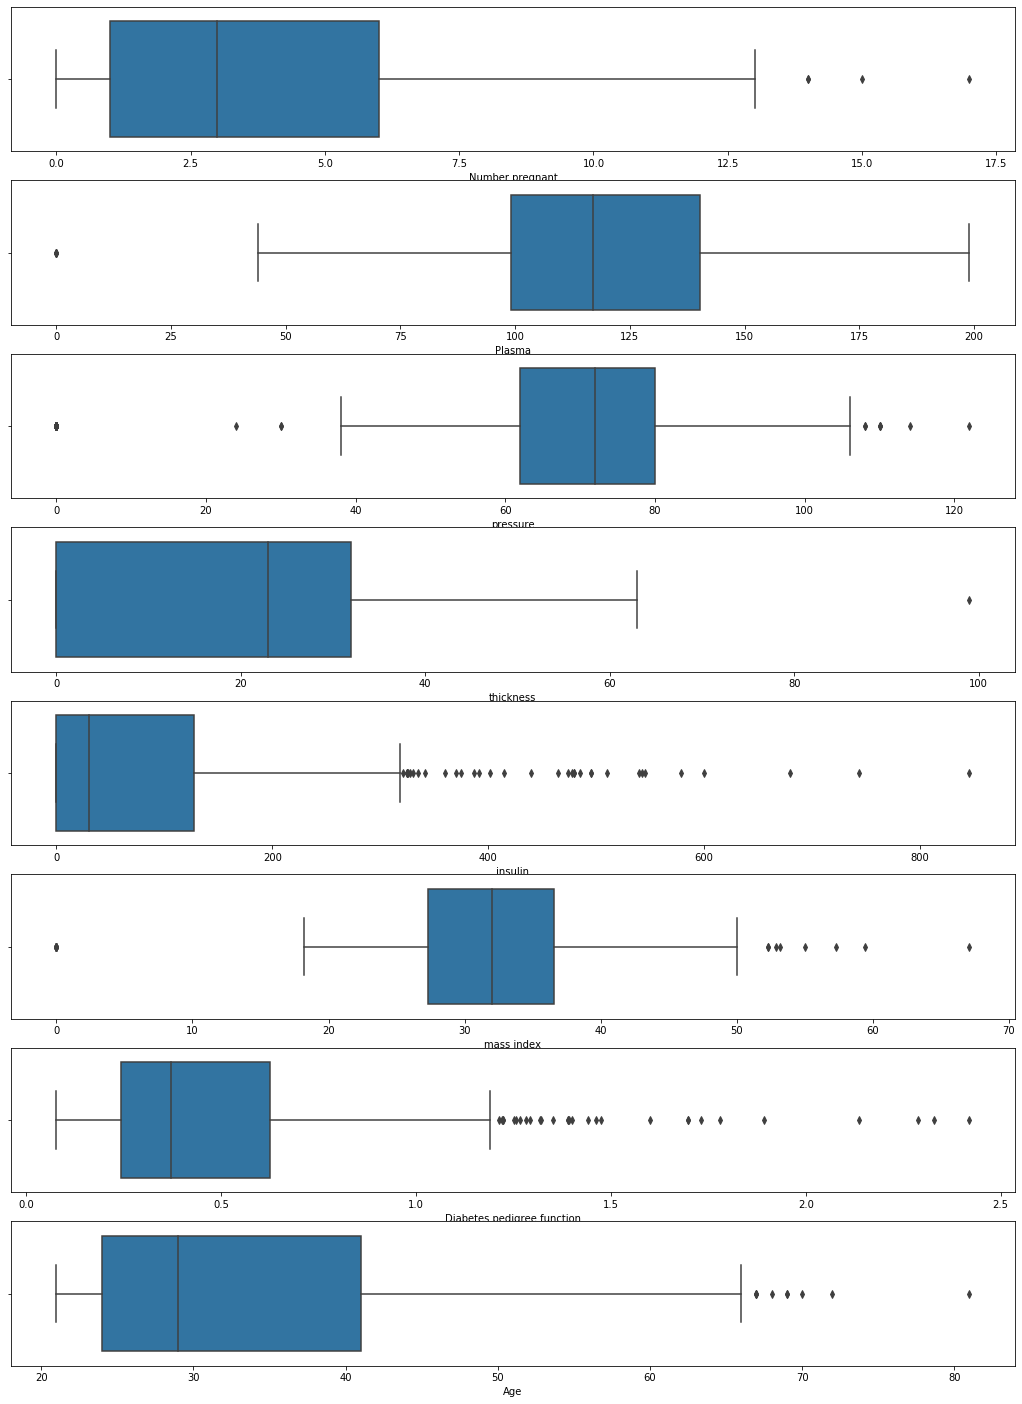

In [24]:
fig,axs = plt.subplots(nrows=8,figsize=(18,25))
#Plot bixplots
i=0
for column in data.columns[:-1]:
    sns.boxplot(data[column],ax=axs[i])
    i += 1
    
for ax in axs:
    ax.ticklabel_format(style='plain',axis='x')
plt.show()

It is very clear now that we have some skewed distributions and several outliers. For example, one can't have a plasma concentration, a blood pressure or a mass index equal to zero. But the number of pregnancies can go up to 40, so the high values observed are not considered as outliers. 

### 4. Data Cleaning

Outliers are going to be replaced with the median.

In [25]:
data.loc[data['Plasma']==0,'Plasma'] = data['Plasma'].median()
data.loc[data['pressure']<35,'pressure'] = data['pressure'].median()
data.loc[data['Plasma']>200,'Plasma'] = data['Plasma'].median()
data.loc[data['Plasma']==0,'Plasma'] = data['Plasma'].median()
data.loc[data['thickness']>80,'thickness'] = data['thickness'].median()
data.loc[data['thickness']==0,'thickness'] = data['thickness'].median()
data.loc[data['insulin']>80,'insulin'] = data['insulin'].median()
data.loc[data['insulin']==0,'insulin'] = data['insulin'].median()
data.loc[data['mass index']>50,'mass index'] = data['mass index'].median()
data.loc[data['mass index']<10,'mass index'] = data['mass index'].median()

In [26]:
def mannwhitney(features,target,dataset):
    result = pd.DataFrame(index=numerical)
    median0 = list()
    median1 = list()
    pv = list()
    
    for col in numerical:
        x = dataset[dataset[target]==0][col]
        y = dataset[dataset[target]==1][col]
        med0, mean0 = round(x.median()), round(x.mean())
        med1, mean1 = round(y.median()), round(y.mean())
        median0.append('{} / {}'.format(med0,mean0))
        median1.append('{} / {}'.format(med1,mean1))
        pv.append(round(st.mannwhitneyu(x,y)[1]))
    result['safe (median/mean)'] = median0
    result['Diabete (Median/mean)'] = median1

    result['P-value'] = pv
    
    return result

def chi_square_test(lignes, var_colonne,data):
    tableau = pd.DataFrame()
    d = data.copy()

    for var_ligne in lignes:
        cont = d[[var_ligne, var_colonne]].pivot_table(index=var_ligne, columns=var_colonne, aggfunc=len).fillna(0).copy().astype(int)
        st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)

        #Ajout des colonnes Stat Chi-2 (valeur de la stat), Nombre de DL et P-value
        chi2 = ['']*len(cont)
        chi2[0] = round(st_chi2,3)

        DL = ['']*len(cont)
        DL[0] = st_dof
        
        feat = ['']*len(cont)
        feat[0] = var_ligne

        PV = ['']*len(cont)
        PV[0] = round(st_p,3)
        cont['Stat Chi-2'] = chi2
        cont['Degrees of Freedom'] = DL
        cont['P-value'] = PV
        cont['Feature'] = feat
        tableau = pd.concat([tableau,cont])
    
    return tableau

In [27]:
numerical = ['Number pregnant', 'Plasma', 'pressure', 'thickness', 'insulin',
       'mass index', 'Diabetes pedigree function', 'Age']
mannwhitney(numerical,'Class',data)

,safe (median/mean),Diabete (Median/mean),P-value
Number pregnant,2 / 3,4 / 5,0
Plasma,108 / 111,140 / 142,0
pressure,72 / 71,74 / 75,0
thickness,23 / 26,27 / 29,0
insulin,30 / 35,30 / 31,0
mass index,30 / 31,34 / 35,0
Diabetes pedigree function,0 / 0,0 / 1,0
Age,27 / 31,36 / 37,0


### 5. Data Engineering

In [28]:
#First, we apply logarith on right skewed features
data['Number pregnant'] = data['Number pregnant'].apply(lambda x: np.log(x+1))
data['insulin'] = data['insulin'].apply(lambda x: np.log(x))
data['Diabetes pedigree function'] = data['Diabetes pedigree function'].apply(lambda x: np.log(x))
data['Age'] = data['Age'].apply(lambda x: np.log(x))

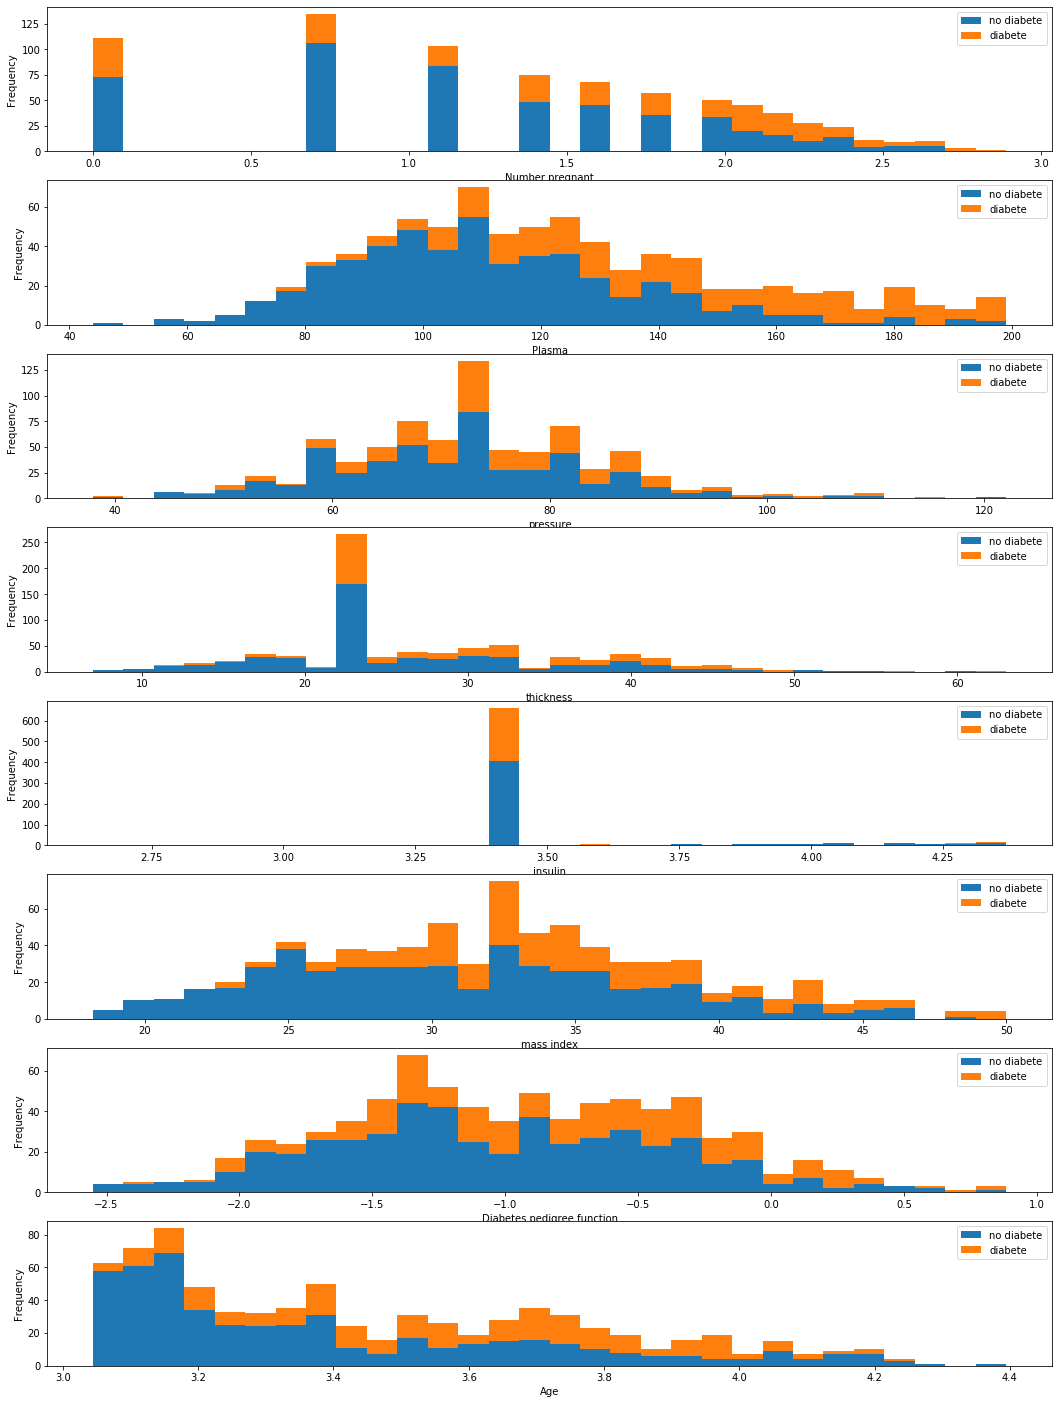

In [29]:
fig,axs = plt.subplots(nrows=8,figsize=(18,25))
#Plot histograms
i=0
for column in data.columns[:-1]:
    plot_distribution(data,column,axs[i],bins=30)
    i += 1

In [30]:
#Splitting data in to train and test data sets
target = data.pop('Class')
X_train,X_test,y_train,y_test = train_test_split(data,target,test_size=0.1)


In [31]:
#Let's now scale he data in order to bring them to the same scale
scaler = StandardScaler()#MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)

In [32]:
#Models
logreg = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=100)

In [33]:
logreg.fit(X_train_sc,y_train)
rfc.fit(X_train_sc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
prediction = pd.DataFrame()
X_test_sc = scaler.transform(X_test)
prediction['observed'] = y_test
prediction['lr_prediction'] = logreg.predict(X_test_sc)
prediction['rfc_prediction'] = rfc.predict(X_test_sc)
prediction

,observed,lr_prediction,rfc_prediction
542,1,0,0
685,0,0,1
479,0,0,0
57,0,0,1
124,1,0,0
...,...,...,...
32,0,0,0
745,0,0,1
287,1,1,1
80,0,0,0


In [35]:
X_test_sc = scaler.transform(X_test)
cm = confusion_matrix(y_test,rfc.predict(X_test_sc))
print('Random Forest prediction')
accuracy = round(100*(cm[0][0]+cm[1][1])/len(y_test),1)
print('Test : {}% accuracy'.format(accuracy))
print(cm)


cm = confusion_matrix(y_test,logreg.predict(X_test_sc))
print('Logistic Regression prediction')
accuracy = round(100*(cm[0][0]+cm[1][1])/len(y_test),1)
print('Test : {}% accuracy'.format(accuracy))
print(cm)


cm = confusion_matrix(y_train,rfc.predict(X_train_sc))
print('Random Forest prediction')
accuracy = round(100*(cm[0][0]+cm[1][1])/len(y_train),1)
print('Train : {}% accuracy'.format(accuracy))
print(cm)

cm = confusion_matrix(y_train,logreg.predict(X_train_sc))
print('Logistic Regression prediction')
accuracy = round(100*(cm[0][0]+cm[1][1])/len(y_train),1)
print('Train : {}% accuracy'.format(accuracy))
print(cm)

Random Forest prediction
Test : 74.0% accuracy
[[43 12]
 [ 8 14]]
Logistic Regression prediction
Test : 77.9% accuracy
[[47  8]
 [ 9 13]]
Random Forest prediction
Train : 100.0% accuracy
[[445   0]
 [  0 246]]
Logistic Regression prediction
Train : 77.1% accuracy
[[388  57]
 [101 145]]


In [36]:
pd.to_pickle(scaler,'scaler.pkl')
pd.to_pickle(rfc,'rfc.pkl')
columns = data.columns
pd.to_pickle(columns,'columns.pkl')

In [37]:
file = open('scaler.pkl','rb')
scaler = pickle.load(file)

file = open('rfc.pkl','rb')
model = pickle.load(file)

file = open('columns.pkl','rb')
columns = pickle.load(file)

In [38]:
new_data = [10,139,80,0,0,27.1,1.4,57]
new_df = pd.DataFrame()

for num in range(len(columns)):
    new_df[columns[num]] = [new_data[num]]

In [39]:
model.predict(scaler.transform(new_df))[0]

0

In [43]:
df = data.copy()
df['prediction'] = model.predict(df)
df[df['prediction']==1]

,Number pregnant,Plasma,pressure,thickness,insulin,mass index,Diabetes pedigree function,Age,prediction
12,2.397895,139.0,80.0,23.0,3.392829,27.1,0.365337,4.043051,1
16,0.000000,118.0,84.0,47.0,3.417727,45.8,-0.596020,3.433987,1
19,0.693147,115.0,70.0,30.0,3.417727,34.6,-0.636767,3.465736,1
27,0.693147,97.0,66.0,15.0,3.417727,23.2,-0.719491,3.091042,1
31,1.386294,158.0,76.0,36.0,3.417727,31.6,-0.161343,3.332205,1
...,...,...,...,...,...,...,...,...,...
740,2.484907,120.0,80.0,37.0,3.417727,42.3,-0.242072,3.871201,1
743,2.302585,140.0,94.0,23.0,3.392829,32.7,-0.309246,3.806662,1
747,0.693147,81.0,74.0,41.0,4.043051,46.3,0.091667,3.465736,1
755,0.693147,128.0,88.0,39.0,3.417727,36.5,0.055435,3.610918,1
